### Import Libraries

In [1]:
# Bibliotecas RAPIDS (GPU)
import cupy as cp
from cuml.pipeline import Pipeline as cumlPipeline
from cuml.preprocessing import StandardScaler as cumlStandardScaler
from cuml.neighbors import KNeighborsClassifier
from cuml.svm import SVC
from cuml.ensemble import RandomForestClassifier as cumlRF
from cuml.metrics import accuracy_score

# Bibliotecas Scikit-learn (CPU)

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold
from sklearn.metrics import classification_report, confusion_matrix as sklearn_confusion_matrix
from sklearn.pipeline import Pipeline as sklearnPipeline
from sklearn.ensemble import RandomForestClassifier as sklearnRF

# Bibliotecas de Extração e Plotagem
import numpy as np
import pandas as pd
import librosa
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
import time
import utils
import subprocess
import io

### Audio Preprocessing

In [2]:
# --- Configuração ---
METADATA_DIR = '../fma_metadata'
AUDIO_DIR_GENRES = '../fma_datasets/fma_small_genres'
FEATURE_FILE_X = '../preprocessed_features/fma_small_windowed_X_518.npy'
FEATURE_FILE_y = '../preprocessed_features/fma_small_windowed_y_518.npy'
FEATURE_FILE_groups = '../preprocessed_features/fma_small_windowed_groups.npy'

# --- Carregar Metadados ---
tracks = utils.load(f'{METADATA_DIR}/tracks.csv')

small_mask = tracks[('set', 'subset')] == 'small'
y_all_labels_pd = tracks.loc[small_mask, ('track', 'genre_top')] # Em pandas
splits_pd = tracks.loc[small_mask, ('set', 'split')] # Em pandas

# --- Codificar os Gêneros (Labels) usando Sklearn ---
label_encoder = LabelEncoder()
# fit_transform em um pandas Series retorna um array numpy
y_all_encoded_np = label_encoder.fit_transform(y_all_labels_pd).astype(np.int32) # Converte para int32

# Criar um DataFrame pandas para referência durante a extração
track_metadata = pd.DataFrame({
    'genre_top': y_all_labels_pd,
    'genre_encoded': y_all_encoded_np,
    'split': splits_pd
}, index=y_all_labels_pd.index)

# Obter nomes das classes para posterior plotagem
class_names = label_encoder.classes_

print(f"Metadados carregados para {track_metadata.shape[0]} faixas 'small'.")
print(f"Gêneros: {class_names}")

Metadados carregados para 8000 faixas 'small'.
Gêneros: ['Electronic' 'Experimental' 'Folk' 'Hip-Hop' 'Instrumental'
 'International' 'Pop' 'Rock']


In [3]:
def calculate_stats(features_matrix):
    """
    Calcula apenas Mean e Std para evitar instabilidade e ruído em janelas curtas.
    """
    result = []
    
    # Garantir que a matriz não esteja vazia
    if features_matrix.size == 0:
        return None 

    # 1. mean
    result.extend(np.mean(features_matrix, axis=1))
    # 2. std
    result.extend(np.std(features_matrix, axis=1))
    # 3. skew
    #result.extend(stats.skew(features_matrix, axis=1))
    # 4. kurtosis
    #result.extend(stats.kurtosis(features_matrix, axis=1))
    # 5. median
    #result.extend(np.median(features_matrix, axis=1))
    # 6. min
    #result.extend(np.min(features_matrix, axis=1))
    # 7. max
    #result.extend(np.max(features_matrix, axis=1))
    
    return np.array(result)

def load_audio_ffmpeg(file_path, sr=22050):
    """
    Carrega áudio usando ffmpeg diretamente para evitar erros de cabeçalho MP3
    que o librosa/audioread falham em ler.
    """
    try:
        # Comando ffmpeg para decodificar para WAV na saída padrão (pipe)
        # -i: entrada
        # -f wav: formato wav
        # -ac 1: mono
        # -ar: sample rate
        # -vn: sem vídeo
        # -: saída para stdout
        command = [
            'ffmpeg', 
            '-i', file_path, 
            '-f', 'wav', 
            '-ac', '1', 
            '-ar', str(sr), 
            '-vn', 
            '-y',  # sobrescrever (não deve ser necessário para pipe, mas boa prática)
            '-loglevel', 'panic', # Silenciar logs
            '-'
        ]
        
        # Executa o comando
        out = subprocess.check_output(command)
        
        # Carrega o buffer de bytes com librosa
        # io.BytesIO transforma os bytes do ffmpeg em um "arquivo em memória"
        y, _ = librosa.load(io.BytesIO(out), sr=sr)
        return y
        
    except Exception as e:
        # Fallback: se ffmpeg falhar (arquivo inexistente ou muito corrompido), tenta librosa puro
        try:
            y, _ = librosa.load(file_path, sr=sr, mono=True)
            return y
        except:
            return None

def extract_features_windowed_full(file_path, window_size_sec=3, overlap_percent=0.25, sr=44100):
    """
    Extrai o conjunto completo de 518 features para cada janela de Ns.
    Esta função é uma adaptação de 'compute_features' de features.py,
    MODIFICADA para aceitar janelas com sobreposição, extração robusta com FFmpeg e obtenção estatísticas simplificadas.
    """
    
    all_window_features = []
    
    # Parâmetros do librosa (como em features.py e baselines.ipynb)
    N_FFT = 2048
    HOP_LENGTH = 512
    N_MFCC = 20
    N_CHROMA = 12
    N_CONTRAST = 7
    
    try:
        # 1. Carregamento
        y = load_audio_ffmpeg(file_path, sr=sr)
        
        if y is None or len(y) == 0:
            return None
        
        # 2. Janelamento
        samples_per_window = window_size_sec * sr
        hop_size = int(samples_per_window * (1.0 - overlap_percent)) # Para 25% de overlap (overlap_percent=0.25), o salto (hop_size) é 75% da janela
        
        # Garante que o áudio tenha pelo menos o tamanho de uma janela
        if len(y) < samples_per_window:
            print(f"Aviso: Áudio {file_path} mais curto que {window_size_sec}s. Pulando.")
            return None

        # Cria as janelas (frames) com sobreposição
        # axis=0 torna y_frames [n_windows, samples_per_window]
        y_frames = librosa.util.frame(y, frame_length=samples_per_window, hop_length=hop_size, axis=0)
        
        # Itera sobre as janelas (frames) para extração
        for y_window in y_frames:
            # STFT e CQT (bases para muitas features)
            stft = np.abs(librosa.stft(y_window, n_fft=N_FFT, hop_length=HOP_LENGTH))
            cqt = np.abs(librosa.cqt(y_window, sr=sr, hop_length=HOP_LENGTH))
            
            window_vector = []
            
            # 1. ZCR
            f = librosa.feature.zero_crossing_rate(y_window, frame_length=N_FFT, hop_length=HOP_LENGTH)
            stats_f = calculate_stats(f)
            if stats_f is None: continue
            window_vector.extend(stats_f)
            
            # 2. Chroma CQT
            f = librosa.feature.chroma_cqt(C=cqt, n_chroma=N_CHROMA)
            stats_f = calculate_stats(f)
            if stats_f is None: continue
            window_vector.extend(stats_f)

            # 3. Chroma CENS
            f = librosa.feature.chroma_cens(C=cqt, n_chroma=N_CHROMA)
            stats_f = calculate_stats(f)
            if stats_f is None: continue
            window_vector.extend(stats_f)
            
            # 4. Chroma STFT
            f = librosa.feature.chroma_stft(S=stft**2, n_chroma=N_CHROMA)
            stats_f = calculate_stats(f)
            if stats_f is None: continue
            window_vector.extend(stats_f)
            
            # 5. RMSE
            f = librosa.feature.rms(S=stft) # Nota: features.py usa 'rmse', mas 'rms' é a função atual
            stats_f = calculate_stats(f)
            if stats_f is None: continue
            window_vector.extend(stats_f)

            # 6. Spectral Centroid
            f = librosa.feature.spectral_centroid(S=stft)
            stats_f = calculate_stats(f)
            if stats_f is None: continue
            window_vector.extend(stats_f)

            # 7. Spectral Bandwidth
            f = librosa.feature.spectral_bandwidth(S=stft)
            stats_f = calculate_stats(f)
            if stats_f is None: continue
            window_vector.extend(stats_f)

            # 8. Spectral Contrast (7 * 7 = 49 features)
            f = librosa.feature.spectral_contrast(S=stft, n_bands=N_CONTRAST - 1)
            stats_f = calculate_stats(f)
            if stats_f is None: continue
            window_vector.extend(stats_f)

            # 9. Spectral Rolloff (1 * 7 = 7 features)
            f = librosa.feature.spectral_rolloff(S=stft)
            stats_f = calculate_stats(f)
            if stats_f is None: continue
            window_vector.extend(stats_f)
            
            # 10. MFCC (20 * 7 = 140 features)
            mel = librosa.feature.melspectrogram(S=stft**2, sr=sr)
            f = librosa.feature.mfcc(S=librosa.power_to_db(mel), n_mfcc=N_MFCC)
            stats_f = calculate_stats(f)
            if stats_f is None: continue
            window_vector.extend(stats_f)
            
            # 11. Tonnetz (6 * 7 = 42 features)
            # (Calculado por último, pois pode depender do chroma_cens)
            f_chroma_cens = librosa.feature.chroma_cens(C=cqt, n_chroma=N_CHROMA) # Recalcula se necessário
            f = librosa.feature.tonnetz(y=librosa.effects.harmonic(y_window), sr=sr, chroma=f_chroma_cens)
            stats_f = calculate_stats(f)
            if stats_f is None: continue
            window_vector.extend(stats_f)
            
            # Adicionar o vetor completo
            all_window_features.append(window_vector)
            
    except Exception as e:
        print(f"Erro ao processar {file_path}: {e}")
        return None # Retorna None em caso de erro de carregamento/processamento
        
    return all_window_features

In [4]:
# Verifica se os arquivos de cache existem
if not (os.path.exists(FEATURE_FILE_X) and 
        os.path.exists(FEATURE_FILE_y) and 
        os.path.exists(FEATURE_FILE_groups)):
    
    print(f"Arquivos de features/grupos não encontrados. Iniciando extração (isso pode levar muito tempo)...")
    
    all_features = []
    all_labels = []
    all_track_ids = []
    
    # Parâmetros de Janelamento
    WINDOW_SIZE_SEC = 3
    OVERLAP_PERCENT = 0.25 # Define a sobreposição
    SR = 22050
    
    for track_id, row in tqdm(track_metadata.iterrows(), total=track_metadata.shape[0]):
        genre_top = row['genre_top']
        # O file path usa o 'genre_top' por causa do script de reorganização
        file_path = f"{AUDIO_DIR_GENRES}/{genre_top}/{track_id:06d}.mp3"
        
        if not os.path.exists(file_path):
            print(f"Aviso: Arquivo não encontrado {file_path}")
            continue
            
        # Passa os novos parâmetros para a função de extração
        window_vectors = extract_features_windowed_full(
            file_path, 
            window_size_sec=WINDOW_SIZE_SEC, 
            overlap_percent=OVERLAP_PERCENT, 
            sr=SR
        )

        if window_vectors is None or len(window_vectors) == 0:
            continue
            
        for vec in window_vectors:
            all_features.append(vec)
            all_labels.append(row['genre_encoded'])
            all_track_ids.append(track_id)

    # Checa se a extração produziu algum dado antes de salvar
    if len(all_features) > 0:
        X_np = np.array(all_features)
        y_encoded_np = np.array(all_labels, dtype=np.int32)
        groups_np = np.array(all_track_ids, dtype=np.int32)
        
        # Lidando com NaNs ou Infs
        X_np = np.nan_to_num(X_np, nan=0.0, posinf=0.0, neginf=0.0)

        print(f"\nExtração concluída. Total de janelas: {X_np.shape[0]}. Features: {X_np.shape[1]}")
        print(f"Salvando features em {FEATURE_FILE_X}...")
        os.makedirs(os.path.dirname(FEATURE_FILE_X), exist_ok=True) # Garante que o dir exista
        np.save(FEATURE_FILE_X, X_np)
        np.save(FEATURE_FILE_y, y_encoded_np)
        np.save(FEATURE_FILE_groups, groups_np)
    else:
        print("\nExtração falhou. Nenhuma feature foi extraída. Verifique se o 'ffmpeg' está instalado.")
        X_np = np.array([])
        y_encoded_np = np.array([], dtype=np.int32)
        groups_np = np.array([], dtype=np.int32)

else:
    print(f"Carregando features cacheadas de {FEATURE_FILE_X}...")
    X_np = np.load(FEATURE_FILE_X)
    y_encoded_np = np.load(FEATURE_FILE_y)
    groups_np = np.load(FEATURE_FILE_groups)
    
    # Lidando com NaNs ou Infs (importante também ao carregar)
    X_np = np.nan_to_num(X_np, nan=0.0, posinf=0.0, neginf=0.0)
    
    print("Features e grupos carregados.")

# --- Checagem de Segurança ---
if X_np.size == 0 or X_np.shape[0] == 0:
    print("\nERRO: O array de features 'X_np' está vazio.")
    print("Por favor, delete os arquivos .npy em 'preprocessed_features/' para forçar a re-extração.")
else:
    print(f"Total de amostras (janelas) para CV: {X_np.shape[0]}")
    print(f"Total de grupos (faixas únicas): {len(np.unique(groups_np))}")
    print(f"Tipo de dado das features (X): {X_np.dtype}")
    print(f"Tipo de dado das labels (y): {y_encoded_np.dtype}")
    print(f"Tipo de dado dos grupos (groups): {groups_np.dtype}")

Carregando features cacheadas de ../preprocessed_features/fma_small_windowed_X_518.npy...
Features e grupos carregados.
Total de amostras (janelas) para CV: 99278
Total de grupos (faixas únicas): 7994
Tipo de dado das features (X): float64
Tipo de dado das labels (y): int32
Tipo de dado dos grupos (groups): int32


### Treino dos Modelos

In [5]:
print("Calculando matriz de correlação para seleção de features...")
X_pd = pd.DataFrame(X_np) # Usando Pandas/CPU pois cabe na memória e é eficiente para estatística
corr_matrix = X_pd.corr().abs()

# Selecionar triângulo superior
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Identificar colunas para remover (correlação > 0.95)
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print(f"Features originais: {X_np.shape[1]}")
print(f"Features a remover: {len(to_drop)}")

# Remover do dataset numpy
# Precisamos criar uma máscara booleana para manter as colunas que NÃO estão em to_drop
keep_mask = np.array([i not in to_drop for i in range(X_np.shape[1])])
X_np_reduced = X_np[:, keep_mask]

print(f"Features finais: {X_np_reduced.shape[1]}")

# Atualiza a variável principal para o CV
X_final = X_np_reduced

Calculando matriz de correlação para seleção de features...
Features originais: 148
Features a remover: 2
Features finais: 146



Iniciando CV 10-Fold para KNN (GPU)...
Treinamento de KNN (GPU) concluído em 6.60 segundos.

Iniciando CV 10-Fold para SVM (GPU)...
Treinamento de SVM (GPU) concluído em 466.27 segundos.

Iniciando CV 10-Fold para Random Forest (CPU)...
Treinamento de Random Forest (CPU) concluído em 1790.64 segundos.

--- Treinamento e Avaliação de CV (Nível Faixa) Concluídos ---

========= Resultados KNN (GPU) (10-Fold CV) - Nível Faixa (Votação Majoritária) ==========
--- Acurácia (Nível Faixa) ---
  Média        : 0.5291
  Desv. Padrão : 0.0136
  Scores (por Fold): [0.52  0.505 0.55  0.526 0.532 0.549 0.542 0.526 0.518 0.523]

========= Resultados SVM (GPU) (10-Fold CV) - Nível Faixa (Votação Majoritária) ==========
--- Acurácia (Nível Faixa) ---
  Média        : 0.6190
  Desv. Padrão : 0.0135
  Scores (por Fold): [0.61  0.625 0.631 0.601 0.626 0.631 0.64  0.596 0.61  0.621]

========= Resultados Random Forest (CPU) (10-Fold CV) - Nível Faixa (Votação Majoritária) ==========
--- Acurácia (Nível Fa

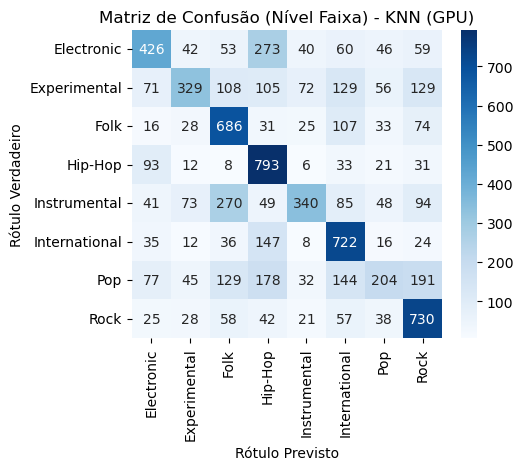


--- Relatório de Classificação (Nível Faixa) ---
               precision    recall  f1-score   support

   Electronic       0.54      0.43      0.48       999
 Experimental       0.58      0.33      0.42       999
         Folk       0.51      0.69      0.58      1000
      Hip-Hop       0.49      0.80      0.61       997
 Instrumental       0.62      0.34      0.44      1000
International       0.54      0.72      0.62      1000
          Pop       0.44      0.20      0.28      1000
         Rock       0.55      0.73      0.63       999

     accuracy                           0.53      7994
    macro avg       0.53      0.53      0.51      7994
 weighted avg       0.53      0.53      0.51      7994

--- SVM (GPU) ---


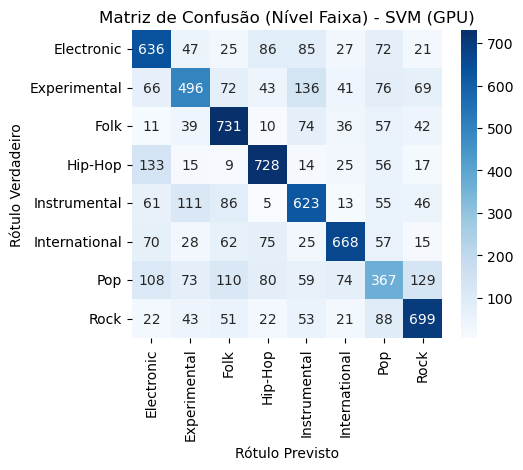


--- Relatório de Classificação (Nível Faixa) ---
               precision    recall  f1-score   support

   Electronic       0.57      0.64      0.60       999
 Experimental       0.58      0.50      0.54       999
         Folk       0.64      0.73      0.68      1000
      Hip-Hop       0.69      0.73      0.71       997
 Instrumental       0.58      0.62      0.60      1000
International       0.74      0.67      0.70      1000
          Pop       0.44      0.37      0.40      1000
         Rock       0.67      0.70      0.69       999

     accuracy                           0.62      7994
    macro avg       0.62      0.62      0.62      7994
 weighted avg       0.62      0.62      0.62      7994

--- Random Forest (CPU) ---


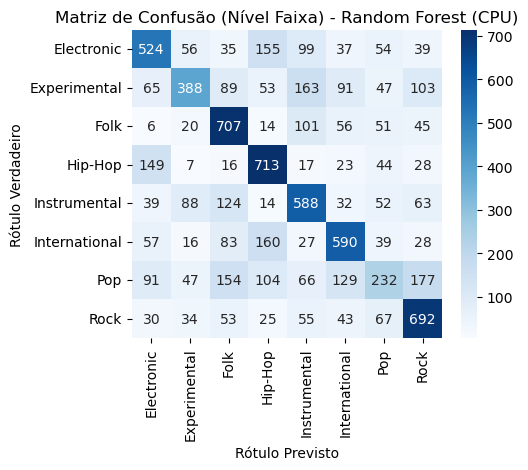


--- Relatório de Classificação (Nível Faixa) ---
               precision    recall  f1-score   support

   Electronic       0.55      0.52      0.53       999
 Experimental       0.59      0.39      0.47       999
         Folk       0.56      0.71      0.63      1000
      Hip-Hop       0.58      0.72      0.64       997
 Instrumental       0.53      0.59      0.56      1000
International       0.59      0.59      0.59      1000
          Pop       0.40      0.23      0.29      1000
         Rock       0.59      0.69      0.64       999

     accuracy                           0.55      7994
    macro avg       0.55      0.55      0.54      7994
 weighted avg       0.55      0.55      0.54      7994



In [6]:
# 1. Definir a Estratégia de CV (GroupKFold - Ponto 1)
n_splits = 10
gkf = GroupKFold(n_splits=n_splits)

# 2. Definir Modelos e Pipelines (cuML - Ponto 3 do usuário)
# (Usando cuML para KNN, SVM e RF, conforme sua atualização)

## Pipeline para KNN (GPU)
pipe_knn = cumlPipeline([
    ('scaler', cumlStandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=11))
])

## Pipeline para SVM (GPU)
pipe_svm = cumlPipeline([
    ('scaler', cumlStandardScaler()),
    ('svm', SVC(kernel='rbf', C=1.0, decision_function_shape="ovo")) 
])

## Pipeline para Random Forest (CPU) - Usando Sklearn e RAM
# Usamos o pipeline do SKLEARN para que o scaler rode na CPU também
pipe_rf_cpu = sklearnPipeline([
    ('rf', sklearnRF(
        n_estimators=1000,   # Seu parâmetro desejado
        max_depth=100,       # Seu parâmetro desejado
        random_state=42,
        n_jobs=-1            # Usa todos os cores da CPU
    ))
])

models = {
    "KNN (GPU)": pipe_knn,
    "SVM (GPU)": pipe_svm,
    "Random Forest (CPU)": pipe_rf_cpu
}

# Dicionários para guardar os resultados (Nível da Faixa)
cv_scores_track = {}
out_of_fold_preds_track = {}


# 3. Executar a Validação Cruzada (GroupKFold + Votação Majoritária)

for model_name, model in models.items():
    print(f"\nIniciando CV {n_splits}-Fold para {model_name}...")
    start_model_time = time.time()
    
    fold_scores_acc = []
    all_preds_for_model = []
    all_true_for_model = []

    for fold, (train_idx, test_idx) in enumerate(gkf.split(X_final, y_encoded_np, groups=groups_np)):
        
        # Índices são numpy
        X_train_np_fold = X_final[train_idx]
        y_train_np_fold = y_encoded_np[train_idx]
        X_test_np_fold = X_final[test_idx]
        y_true_window_np = y_encoded_np[test_idx]
        track_ids_test_fold = groups_np[test_idx]

        if "GPU" in model_name:
            # --- Bloco GPU (cuML) ---
            X_train_cp = cp.array(X_train_np_fold)
            y_train_cp = cp.array(y_train_np_fold, dtype=cp.int32)
            X_test_cp = cp.array(X_test_np_fold)
            
            model.fit(X_train_cp, y_train_cp)
            
            y_pred_cp = model.predict(X_test_cp)
            
            y_pred_window_np = cp.asnumpy(y_pred_cp) # De volta para CPU
            
            del X_train_cp, y_train_cp, X_test_cp, y_pred_cp # Limpa VRAM
        
        else:
            # --- Bloco CPU (Sklearn) ---
            # 'model' aqui é o pipe_rf_cpu do sklearn
            model.fit(X_train_np_fold, y_train_np_fold)
            y_pred_window_np = model.predict(X_test_np_fold) # Já está em NumPy

        
        # --- Agregação (PONTO 2: Votação Majoritária) ---
        # (Esta parte é sempre na CPU)
        
        df_fold = pd.DataFrame({
            'track_id': track_ids_test_fold,
            'y_true_window': y_true_window_np,
            'y_pred_window': y_pred_window_np
        })

        grouped = df_fold.groupby('track_id')
        y_true_track = grouped['y_true_window'].first()
        y_pred_track = grouped['y_pred_window'].apply(lambda x: stats.mode(x, keepdims=True)[0][0])
        
        acc_fold_track = accuracy_score(y_true_track, y_pred_track)
        fold_scores_acc.append(acc_fold_track)
        
        all_preds_for_model.append(y_pred_track.values)
        all_true_for_model.append(y_true_track.values)
    
    # --- Fim do Loop CV ---
    
    cv_scores_track[model_name] = {
        'Acurácia (Nível Faixa)': np.array(fold_scores_acc)
    }
    
    y_true_final = np.concatenate(all_true_for_model)
    y_pred_final = np.concatenate(all_preds_for_model)
    
    out_of_fold_preds_track[model_name] = {
        'y_true': y_true_final,
        'y_pred': y_pred_final
    }
    
    end_model_time = time.time()
    print(f"Treinamento de {model_name} concluído em {end_model_time - start_model_time:.2f} segundos.")


print("\n--- Treinamento e Avaliação de CV (Nível Faixa) Concluídos ---")

# 4. Analisar Resultados (Relatório de Métricas Nível Faixa)
for model_name, metrics in cv_scores_track.items():
    print(f"\n========= Resultados {model_name} ({n_splits}-Fold CV) - Nível Faixa (Votação Majoritária) ==========")
    
    for metric_name, scores_cpu in metrics.items():
        print(f"--- {metric_name} ---")
        print(f"  Média        : {scores_cpu.mean():.4f}")
        print(f"  Desv. Padrão : {scores_cpu.std():.4f}")
        print(f"  Scores (por Fold): {np.round(scores_cpu, 3)}")

# 5. Análise (Matrizes de Confusão Nível Faixa)
print("\n\n========= Matrizes de Confusão (Agregadas da CV) - Nível Faixa ==========")

for model_name, results in out_of_fold_preds_track.items():
    print(f"--- {model_name} ---")
    
    y_true_agg = results['y_true']
    y_pred_agg = results['y_pred']
    
    cm_cpu = sklearn_confusion_matrix(y_true_agg, y_pred_agg)
    
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm_cpu, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Matriz de Confusão (Nível Faixa) - {model_name}')
    plt.ylabel('Rótulo Verdadeiro')
    plt.xlabel('Rótulo Previsto')
    plt.show()
    
    print("\n--- Relatório de Classificação (Nível Faixa) ---")
    print(classification_report(y_true_agg, y_pred_agg, target_names=class_names))